In [1]:
import numpy as np; from matplotlib.pyplot import *
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
from numba import jit
import os
from sklearn.cluster import KMeans; from sklearn.cluster import MiniBatchKMeans
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/')
import fileread as fr; import wave_ops as wo;import predefined as pd

In [2]:
runs=[run for run in os.listdir('/media/noah/Data/calcium_WF_data/') \
      if run.endswith('0.bin') and run[4:-6]!='186']
runs.sort()
print(runs)

['Run_100_0.bin', 'Run_120_0.bin', 'Run_131_0.bin', 'Run_38_0.bin', 'Run_46_0.bin', 'Run_59_0.bin', 'Run_76_0.bin', 'Run_79_0.bin']


In [10]:
bdch=11
bd,ch=divmod(bdch,8)
cal=pd.calibration[(pd.calibration.board==bd)*(pd.calibration.channel==ch)][0]
wfs=[]

runs=[run for run in os.listdir('/media/noah/Data/calcium_WF_data/') \
      if run.endswith('0.bin') and run[4:-6]!='186']
runs.sort()
mn,mx=520,1460
for run in runs:
    print('\r'+30*' ',end='')
    print('\r'+run,end='')
    data=fr.raw('/media/noah/Data/calcium_WF_data/'+run,numwaves=300000).view(np.recarray)
    t=(data.board==bd)*(data.channel==ch)
    data=data[t]
    wo.baseline_restore(data)
    maxes=np.amax(data.wave,axis=1)
    t=(maxes>mn)*(maxes<mx)
    wfs.append(data.wave[t])
# print(np.vstack(wfs).shape)
wfs=np.vstack(wfs)
del data

Run_79_0.bin                  

In [11]:
X=wfs.copy().astype('f4')

In [12]:
@jit(nopython=True)
def normBatch(x):
    for i in range(len(x)):
        x[i] = x[i] - np.amin(x[i])
        x[i] = x[i]*2./np.amax(x[i])
        x[i] = x[i] - 1
    return x
normBatch(np.empty((2,len(X[0]))));
X=normBatch(X)



In [13]:
kmean = MiniBatchKMeans(n_clusters=8, n_init=100,batch_size=1000)
# kmean = KMeans(n_clusters=8, n_init=100)
kmean.fit(X);
pred_labels=kmean.predict(X)

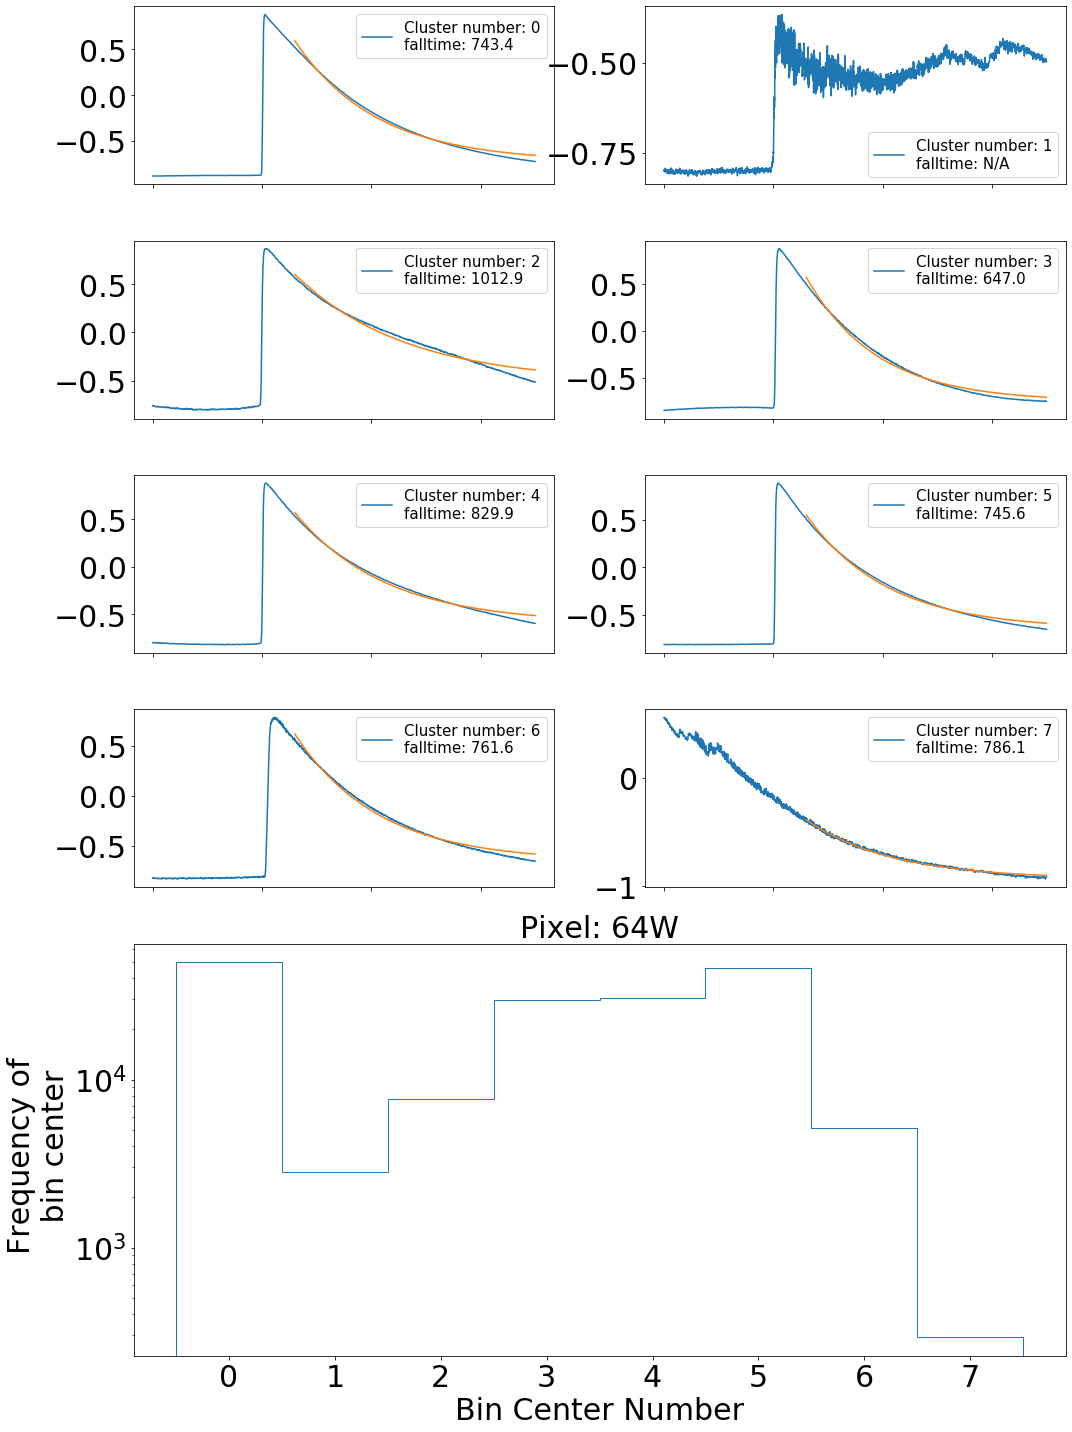

In [14]:
fs=30
nrows,rem=divmod(len(kmean.cluster_centers_),2)
nrows+=rem
ncols=2
h,b=np.histogram(pred_labels,bins=len(kmean.cluster_centers_),\
        range=[0,len(kmean.cluster_centers_)])
t=np.arange(len(kmean.cluster_centers_[0]))

fig=figure(1,figsize=(15,nrows*5))
for i,wave in enumerate(kmean.cluster_centers_):
# for i,wave in enumerate(wfs[20:26]):
    r,c=divmod(i,2)
    t0=1300
    fit_x=t[t>t0]
    fit_y=wave[t>t0]
    off=min(fit_y)
    fit_y-=off
    decay = lambda t,a,tau: a*np.exp(-t.astype(float)/tau)
    pars,vrs=curve_fit(decay,fit_x,fit_y,p0=[max(fit_y-min(fit_y)),1000])

    ax=subplot2grid((nrows+1+1,2),(r,c))
    if pars[1]<3e3:
        ax.plot(wave,label='Cluster number: {:0d}\nfalltime: {:0.1f}'.format(i,pars[1]))
        ax.plot(fit_x,decay(fit_x,*pars)+off)
    else:
        ax.plot(wave,label='Cluster number: {:0d}\nfalltime: N/A'.format(i))
    ax.tick_params(labelsize=fs)
    ax.legend(fontsize=fs-15)
    ax.set_xticklabels('')
# ax=fig.add_subplot(nrows=nrows+1,ncols=1)
# ax.hist(pred_labels,bins=len(kmean.cluster_centers_),\
#         range=[0,len(kmean.cluster_centers_+1)],histtype='step')
ax=subplot2grid((nrows+1+1,2),(nrows,0),colspan=2,rowspan=2)
ax.hist(pred_labels,bins=len(kmean.cluster_centers_),align='left',\
        range=[0,len(kmean.cluster_centers_)],histtype='step')
# ax.plot(b[:-1]-0.5,h,ds='steps')
ax.set_yscale('log')
ax.tick_params(labelsize=fs)
fig.tight_layout()
ax.set_title('Pixel: '+pd.pixel(bd,ch),fontsize=fs)
ax.set_ylabel('Frequency of \n bin center',fontsize=fs)
ax.set_xlabel('Bin Center Number',fontsize=fs)
savefig('Clusters-'+pd.pixel(bd,ch))
fig.tight_layout()
show()
# legend()

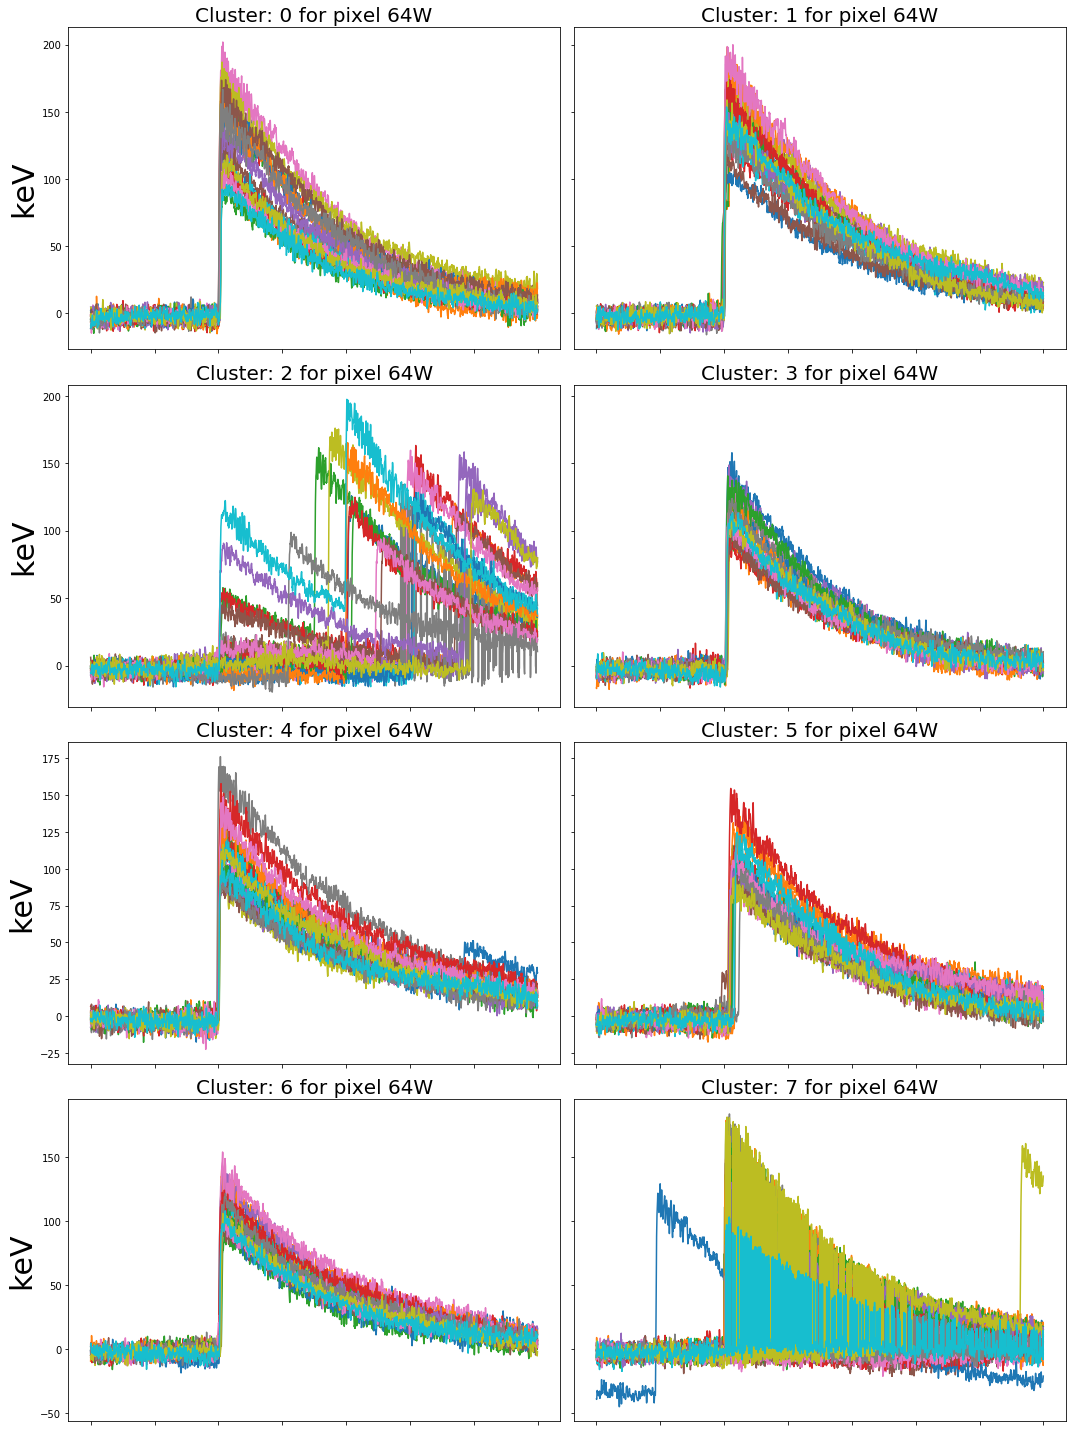

In [8]:
nrows,rem=divmod(len(kmean.cluster_centers_),2)
nrows+=rem


labels=kmean.predict(X)
fig,ax=subplots(nrows=nrows,ncols=2,figsize=(15,20),sharex='col',sharey='row')
for i in range(len(kmean.cluster_centers_)):
    r,c=divmod(i,2)
    off=5
    num=20
    x=(wfs[labels==i][off:off+num]-cal.offset)/cal.slope
    for j in range(num):
        ax[r,c].plot(x[j])
    if c==0:
        ax[r,c].set_ylabel('keV',fontsize=fs)
    ax[r,c].set_title('Cluster: {:0d} for pixel '.format(i)+pd.pixel(bd,ch),fontsize=fs-10)
    ax[r,c].set_xticklabels('')
fig.tight_layout()
savefig('waves_with_centers-'+pd.pixel(bd,ch))
show()

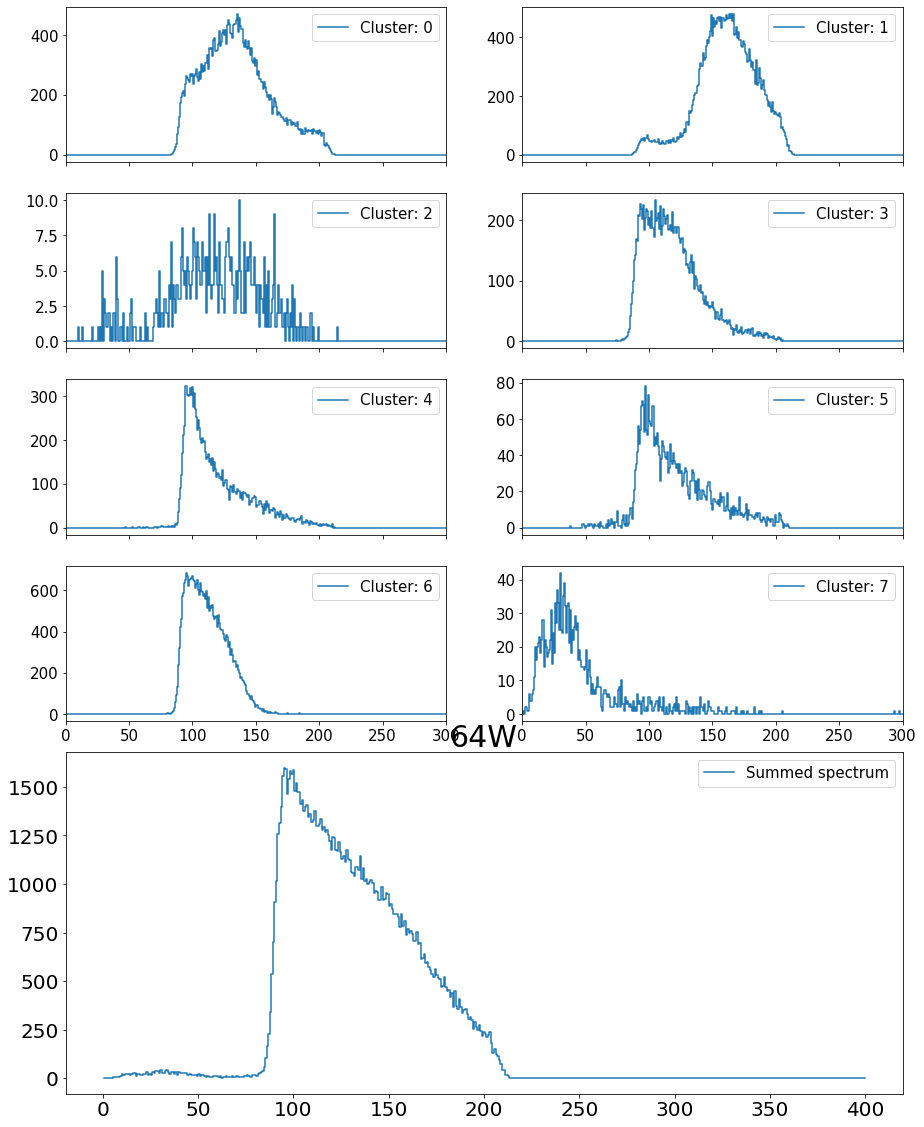

In [9]:

trp=np.zeros(3500).astype(float)
rise,top,fall=300,100,1000
wo.trap(trp,300,100,wo.means[bdch])
trp=trp/(rise*fall)



rows,rem=divmod(len(kmean.cluster_centers_),2)
rows+=rem

# fig,ax=subplots(nrows=rows,ncols=2,figsize=(15,10),sharex='col')
full_h=np.zeros(500,dtype=float)
fig=figure(figsize=(15,20))
for i in range(len(kmean.cluster_centers_)):
    r,c=divmod(i,2)
    x=wfs[labels==i]
    energies = np.amax(np.apply_along_axis(lambda m: fftconvolve(m,trp)[0:len(t)],1,x),axis=1)
    ax=subplot2grid((rows+2,2),(r,c))
    h,b=np.histogram((energies- cal.offset)/cal.slope,bins=500,range=[0,400])
    full_h+=h
    b=pd.cbins(b)
    ax.plot(b,h,ds='steps',label='Cluster: {:0d}'.format(i))
    ax.legend(fontsize=fs-15)
    ax.tick_params(labelsize=fs-15)
    ax.set_xlim(0,300)
    if r!=rows-1:
        ax.set_xticklabels('')

ax=subplot2grid((rows+2,2),(rows,0),colspan=2,rowspan=2)

ax.plot(b,full_h,ds='steps',label='Summed spectrum')
ax.tick_params(labelsize=fs-10)
ax.legend(fontsize=fs-15)
ax.set_title(pd.pixel(bd,ch),fontsize=fs)
savefig('Cluster_spectra-'+pd.pixel(bd,ch))
show()

In [30]:
if bdch+24 >47:
    bdch=bdch-24
else:
    bdch=bdch+24
bd,ch=divmod(bdch,8)
cal=pd.calibration[(pd.calibration.board==bd)*(pd.calibration.channel==ch)][0]
wfs=[]

runs=[run for run in os.listdir('/media/noah/Data/calcium_WF_data/') \
      if run.endswith('0.bin') and run[4:-6]!='186']
runs.sort()
# runs=[runs[0]]
for run in runs:
    print('\r'+30*' ',end='')
    print('\r'+run,end='')
    data=fr.raw('/media/noah/Data/calcium_WF_data/'+run,numwaves=300000).view(np.recarray)
    t=(data.board==bd)*(data.channel==ch)
    data=data[t]
    wo.baseline_restore(data)
    maxes=np.amax(data.wave,axis=1)
    t=(maxes>mn)*(maxes<mx)
    wfs.append(data.wave[t])
# print(np.vstack(wfs).shape)
wfs=np.vstack(wfs)
del data

Run_79_0.bin                  

In [31]:
X=wfs.copy().astype('f4')

In [32]:
@jit(nopython=True)
def normBatch(x):
    for i in range(len(x)):
        x[i] = x[i] - np.amin(x[i])
        x[i] = x[i]*2./np.amax(x[i])
        x[i] = x[i] - 1
    return x
normBatch(np.empty((2,len(X[0]))));
X=normBatch(X)



In [33]:
pred_labels=kmean.predict(X)

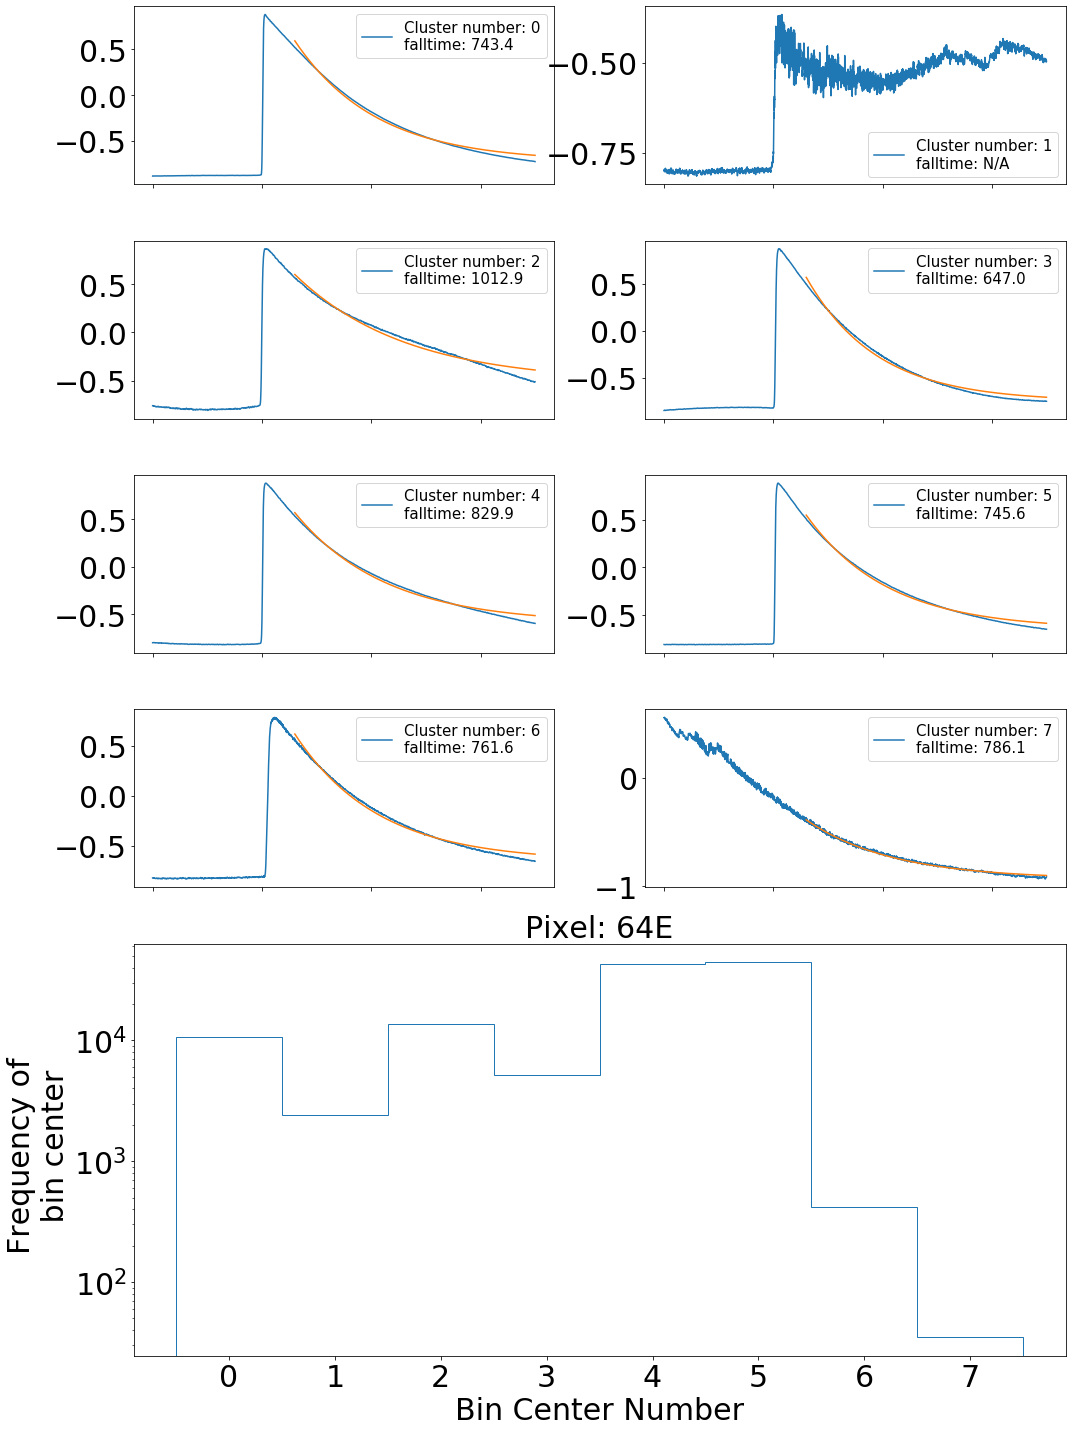

In [34]:
fs=30
nrows,rem=divmod(len(kmean.cluster_centers_),2)
nrows+=rem
ncols=2
h,b=np.histogram(pred_labels,bins=len(kmean.cluster_centers_),\
        range=[0,len(kmean.cluster_centers_)])
t=np.arange(len(kmean.cluster_centers_[0]))

fig=figure(1,figsize=(15,nrows*5))
for i,wave in enumerate(kmean.cluster_centers_):
# for i,wave in enumerate(wfs[20:26]):
    r,c=divmod(i,2)
    t0=1300
    fit_x=t[t>t0]
    fit_y=wave[t>t0]
    off=min(fit_y)
    fit_y-=off
    decay = lambda t,a,tau: a*np.exp(-t.astype(float)/tau)
    pars,vrs=curve_fit(decay,fit_x,fit_y,p0=[max(fit_y-min(fit_y)),1000])

    ax=subplot2grid((nrows+1+1,2),(r,c))
    if pars[1]<3e3:
        ax.plot(wave,label='Cluster number: {:0d}\nfalltime: {:0.1f}'.format(i,pars[1]))
        ax.plot(fit_x,decay(fit_x,*pars)+off)
    else:
        ax.plot(wave,label='Cluster number: {:0d}\nfalltime: N/A'.format(i))
    ax.tick_params(labelsize=fs)
    ax.legend(fontsize=fs-15)
    ax.set_xticklabels('')
# ax=fig.add_subplot(nrows=nrows+1,ncols=1)
# ax.hist(pred_labels,bins=len(kmean.cluster_centers_),\
#         range=[0,len(kmean.cluster_centers_+1)],histtype='step')
ax=subplot2grid((nrows+1+1,2),(nrows,0),colspan=2,rowspan=2)
ax.hist(pred_labels,bins=len(kmean.cluster_centers_),align='left',\
        range=[0,len(kmean.cluster_centers_)],histtype='step')
# ax.plot(b[:-1]-0.5,h,ds='steps')
ax.set_yscale('log')
ax.tick_params(labelsize=fs)
fig.tight_layout()
ax.set_title('Pixel: '+pd.pixel(bd,ch),fontsize=fs)
ax.set_ylabel('Frequency of \n bin center',fontsize=fs)
ax.set_xlabel('Bin Center Number',fontsize=fs)
savefig('Clusters-comp-'+pd.pixel(bd,ch))
fig.tight_layout()
show()
# legend()

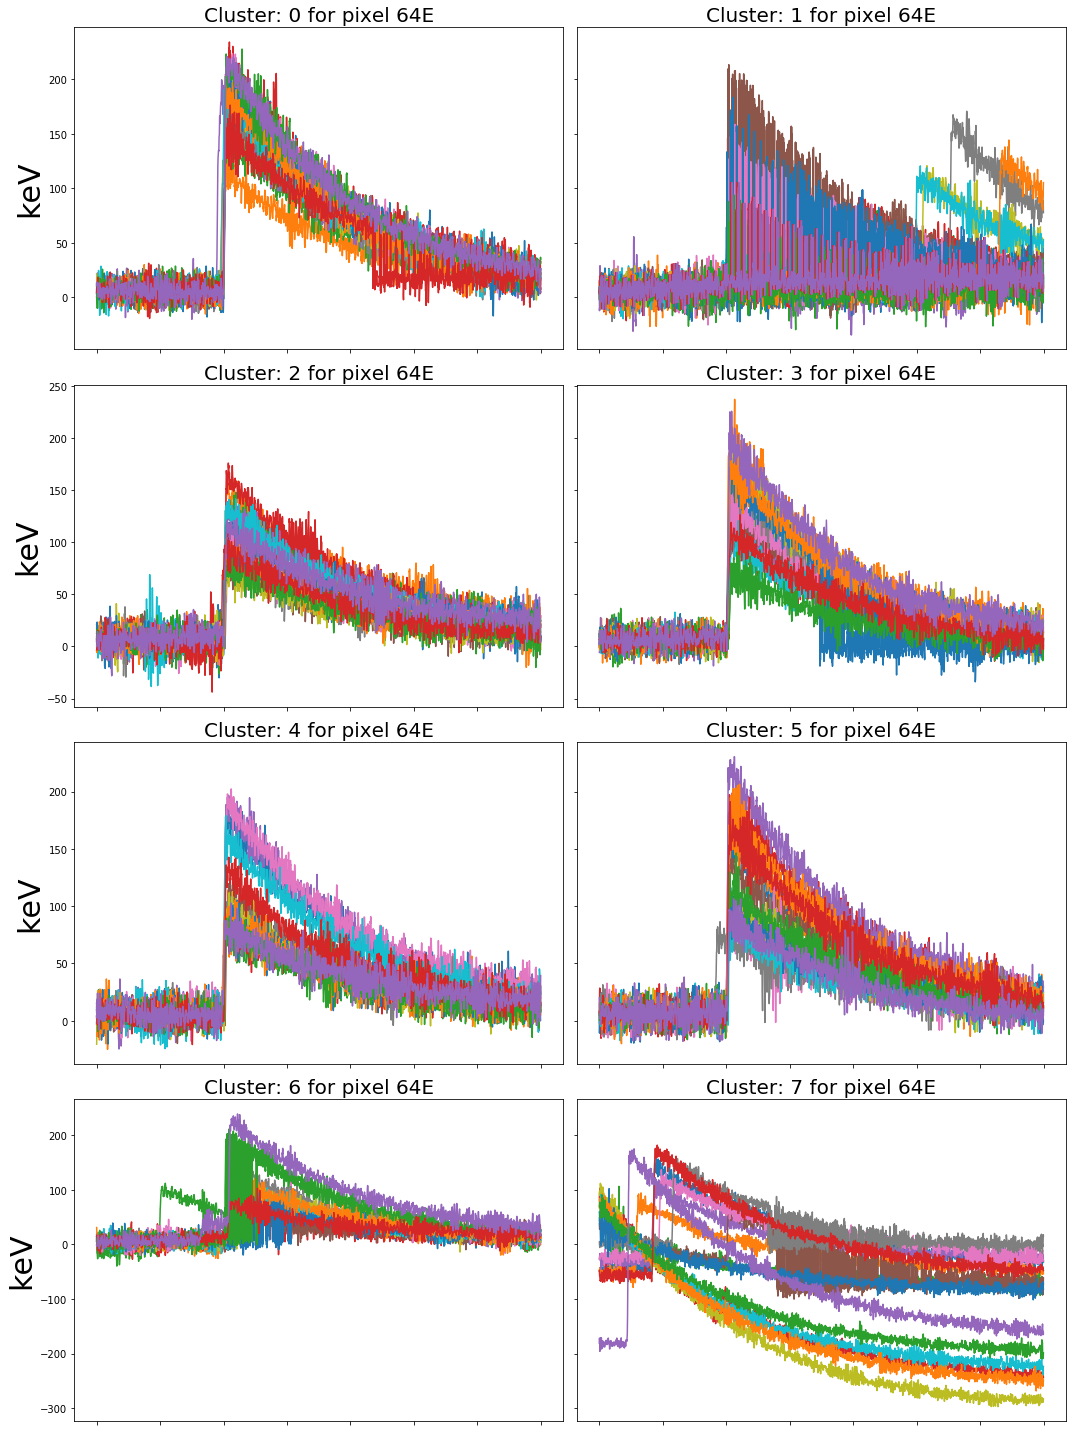

In [35]:
nrows,rem=divmod(len(kmean.cluster_centers_),2)
nrows+=rem


labels=kmean.predict(X)
fig,ax=subplots(nrows=nrows,ncols=2,figsize=(15,20),sharex='col',sharey='row')
for i in range(len(kmean.cluster_centers_)):
    r,c=divmod(i,2)
    off=5
    num=15
    x=(wfs[labels==i][off:off+num]-cal.offset)/cal.slope
    for j in range(num):
        ax[r,c].plot(x[j])
    if c==0:
        ax[r,c].set_ylabel('keV',fontsize=fs)
    ax[r,c].set_title('Cluster: {:0d} for pixel '.format(i)+pd.pixel(bd,ch),fontsize=fs-10)
    ax[r,c].set_xticklabels('')
fig.tight_layout()
savefig('waves_with_centers-comp-'+pd.pixel(bd,ch))
show()

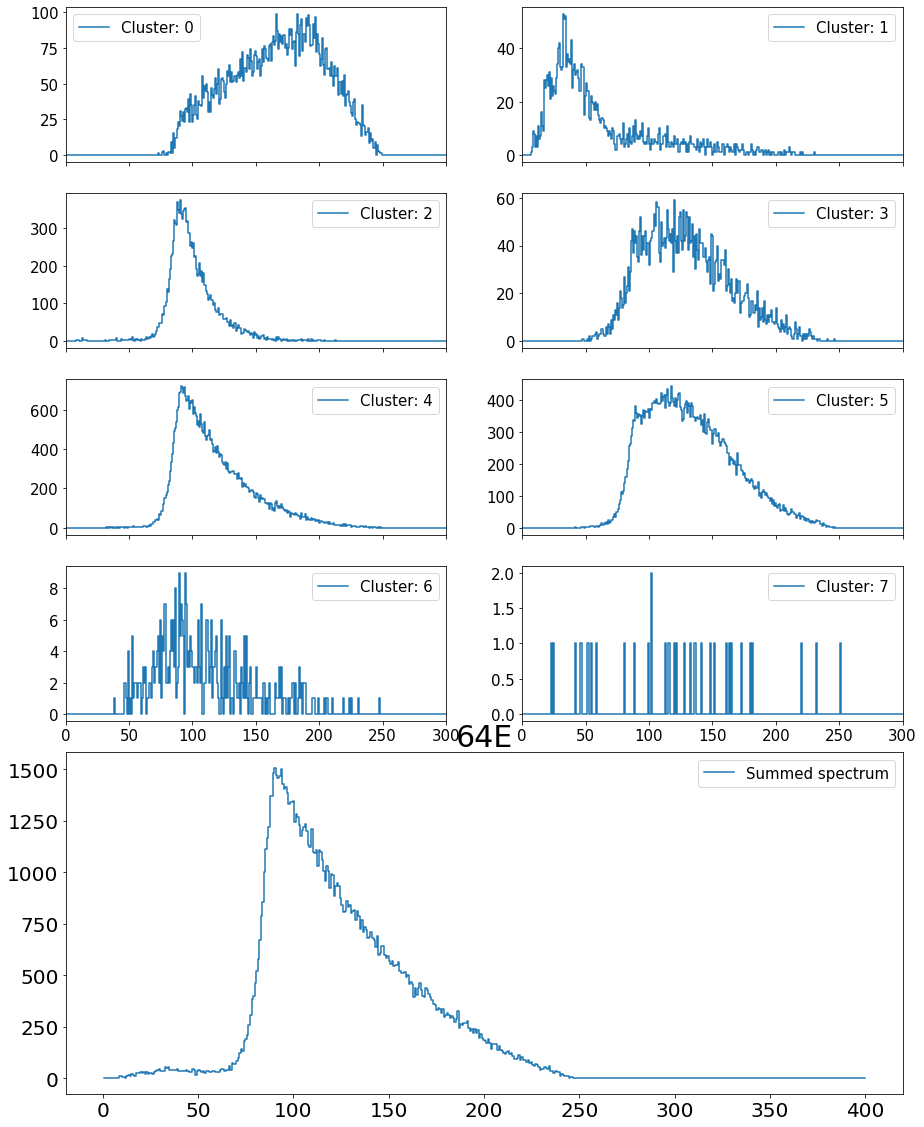

In [36]:

trp=np.zeros(3500).astype(float)
rise,top,fall=300,100,1000
wo.trap(trp,300,100,wo.means[bdch])
trp=trp/(rise*fall)



rows,rem=divmod(len(kmean.cluster_centers_),2)
rows+=rem

# fig,ax=subplots(nrows=rows,ncols=2,figsize=(15,10),sharex='col')
full_h=np.zeros(500,dtype=float)
fig=figure(figsize=(15,20))
for i in range(len(kmean.cluster_centers_)):
    r,c=divmod(i,2)
    x=wfs[labels==i]
    energies = np.amax(np.apply_along_axis(lambda m: fftconvolve(m,trp)[0:len(t)],1,x),axis=1)
    ax=subplot2grid((rows+2,2),(r,c))
    h,b=np.histogram((energies- cal.offset)/cal.slope,bins=500,range=[0,400])
    full_h+=h
    b=pd.cbins(b)
    ax.plot(b,h,ds='steps',label='Cluster: {:0d}'.format(i))
    ax.legend(fontsize=fs-15)
    ax.tick_params(labelsize=fs-15)
    ax.set_xlim(0,300)
    if r!=rows-1:
        ax.set_xticklabels('')

ax=subplot2grid((rows+2,2),(rows,0),colspan=2,rowspan=2)

ax.plot(b,full_h,ds='steps',label='Summed spectrum')
ax.tick_params(labelsize=fs-10)
ax.legend(fontsize=fs-15)
ax.set_title(pd.pixel(bd,ch),fontsize=fs)
savefig('Cluster_spectra-comp-'+pd.pixel(bd,ch))
show()